# EDS Processing Part 1: Pre-Processing and Multivariate Statistical Analysis
**Author:** Lukas Grünewald  
**Last edited:** 25.10.23  
**HyperSpy Version:** 1.7.5

### Purpose:
This notebook can be used to process EDS spectrum images (SIs), typically of shape ($x$, $y$|$E$) with the spatial scan dimensions $x$ and $y$ and the energy channels $E$.  
It was created for Bruker .bcf files, but other supported data formats work as well (see [https://hyperspy.org/rosettasciio/supported_formats/index.html](https://hyperspy.org/rosettasciio/supported_formats/index.html)). We only need to have the EDS dataset in the general shape ($x$, $y$|$E$) after loading the data.

What is meant with *pre-processing*?  
--> Cropping, rotating, binning, etc. of the multidimensional dataset.  
What is meant with *multivariate statistical analysis (MSA)*?  
--> Dimensionality reduction with principal component analysis (PCA) can be used to reduce noise. Qualitative elemental maps can then be extracted from the denoised datacube. Additionally, blind source separation  such indipendent component analysis (ICA) or other decomposition algorithms such as non-negative matrix factorization (NMF) can be used to attempt to unmix overlapping chemical signals in EDS spectra (e.g. overlapping core/shell signal of a core-shell-nanoparticle), thereby directly retrieving sensible chemical phases.

### Usage:
Create a working folder containing this notebook and the .bcf (or other EDS) file. It is recommended to use a copy of this notebook and **Part2-SignalExtraction** for *every* EDS mapping you want to process. In this way, you can easily revisit your analysis later on and also share it more easily, e.g., on Zenodo together with your publication.

If you are not familiar with Jupyter notebooks here are some basic usage tips:
  * A single cells can be run by ``Shift+Enter``. This notebook is mostly run from top to bottom. Some cells are optional and can be skipped (e.g., spatial cropping).
  * If a cell is surrounded in green: You can change the code/text inside. Click outside to make it blue to leave the 'editor mode'.
  * Outside 'editor mode': Add new cell with ``a`` (above) or ``b`` (below). Delete current cell with ``dd``.  
  Change cell type from *code* to *text* (markdown) with ``m`` to add comments like this here. You can switch back to a code cell by using ``y``.

# Analysis

In [1]:
# Use watermark package to document package versions and hardware info
%load_ext watermark
# We use the widget backend for the explained notebooks
# Use qt for actual use with traitsui elements
%matplotlib widget

# Main packages
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Extras
from scipy.ndimage import rotate
from tifffile import imwrite
import os
from pathlib import Path # Deal with Windows/Unix path issues

In [2]:
%watermark -i -v -u -m --iversions

Last updated: 2023-10-25T11:17:23.482349+02:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.16.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.5.6-100.fc37.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

numpy     : 1.24.4
matplotlib: 3.8.0
hyperspy  : 1.7.5



#### Load data

In [3]:
path = Path(os.getcwd())# Path to EDS file, recommended to be in same folder as the notebooks
file = 'EDS_dataset.bcf' # filename

In [4]:
s = hs.load(path / file, 
            select_type='spectrum_image',
            convert_units=True)

#### Print data set information

In [5]:
print(f'Data set:\t\t\t\t{s}') # print info on data
print(f'Acquisition date:\t\t\t{s.metadata.General.date}')
print(f'Dimensions of SI data:\t\t\t{np.shape(s)}')
print(f'Total x-ray counts:\t\t\t{s.sum(-1).sum().data[0]}')
print(f'Average x-ray counts per pixel:\t\t{np.mean(s.sum(-1).data):.0f}')
print(f'Spatial sampling:\t\t\t{s.axes_manager[0].scale:.6f} {s.axes_manager[0].units}/pixel')
print(f'Energy sampling (energy dispersion):\t{s.axes_manager[-1].scale:.6f} {s.axes_manager[-1].units}/channel')
print(f'Energy resolution (Mn Ka):\t\t{s.metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa:.2f} eV')
print(f'Live time:\t\t\t\t{s.metadata.Acquisition_instrument.TEM.Detector.EDS.live_time} s')
print(f'Real time:\t\t\t\t{s.metadata.Acquisition_instrument.TEM.Detector.EDS.real_time} s')
print(f'Dead time:\t\t\t\t{(1 - s.metadata.Acquisition_instrument.TEM.Detector.EDS.live_time/s.metadata.Acquisition_instrument.TEM.Detector.EDS.real_time) * 100:.1f} %')
print(f'Effective count rate:\t\t\t{s.sum(-1).sum().data[0]/s.metadata.Acquisition_instrument.TEM.Detector.EDS.real_time:.0f} counts/s')
print(f'Primary energy:\t\t\t\t{s.metadata.Acquisition_instrument.TEM.beam_energy} keV')

Data set:				<EDSTEMSpectrum, title: EDX, dimensions: (180, 260|2048)>
Acquisition date:			2020-04-28
Dimensions of SI data:			(260, 180, 2048)
Total x-ray counts:			8457242
Average x-ray counts per pixel:		181
Spatial sampling:			0.216275 nm/pixel
Energy sampling (energy dispersion):	0.010013 keV/channel
Energy resolution (Mn Ka):		130.00 eV
Live time:				974.522 s
Real time:				1015.632 s
Dead time:				4.0 %
Effective count rate:			8327 counts/s
Primary energy:				200.0 keV


#### Inspect data
Move the small, red ROI marker in the top left corner to inspect the SI signal.  
Useful hotkeys with the interactive figure selected: Arrow keys to move around, `+/-` to increase ROI marker, `e` to add a second marker.  
Link for more information: https://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html

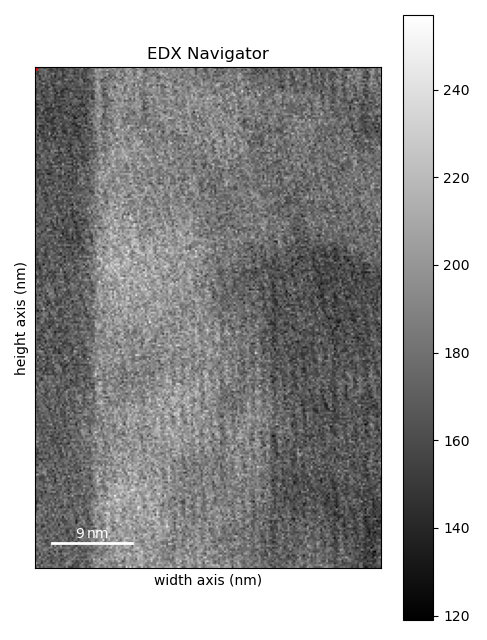

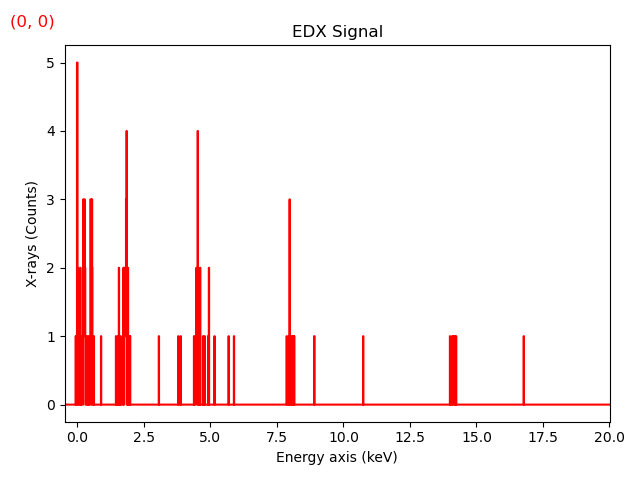

In [6]:
s.plot() 

#### Define helper functions

In [7]:
def create_folder(folderpath):
    """
    Create a folder.

    Parameters
    ----------
    folderpath : Path and name of folder. 
    """
    try: os.mkdir(folderpath)
    except OSError: print(f'Creation of the directory {folderpath} failed. Probably already present.')
    else: print(f'Successfully created the directory {folderpath}')
    
def save_scaled_tiff(s, filename):
    """
    Save 2D HyperSpy signal as 32-bit scaled tiff for ImageJ/Fiji.
    The scale and unit is taken from the axis_manager of s. 
    Make sure s.axes_manager.scale and s.axes_manager.units are correct.

    Parameters
    ----------
    s : 2D HyperSpy signal
    filename : path/to/output.tif
    """
    # Create temporary copy of s
    s2 = s.deepcopy()
    s2.change_dtype('float32') # from float64
    
    # Failsave for tiff scale: µ cannot be set, use u instead
    unit = s2.axes_manager[-1].units
    if s2.axes_manager[-1].units== 'µm':
        unit = 'um'
        
    # Save file
    imwrite(filename, s2.data, 
            imagej=True, 
            resolution=(1./s.axes_manager[-1].scale, 1./s.axes_manager[-1].scale), 
            metadata={'unit': unit})
    
    # Clean up
    del s2

Create additional directories to save results:

In [8]:
# Main subdirectory for results
hyperspy_path = path / 'HyperSpy_Analysis'
create_folder(hyperspy_path); 

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis


#### Save derived spectra and metadata
At the moment, we only calculate the derived spectrum of the summed-up x-ray counts ("SumSpectrum").

In [9]:
s.sum().save(hyperspy_path / 'SumSpectrum.msa', overwrite=True)
s.original_metadata.export(hyperspy_path / 'Original_Metadata.txt')

#### Save overview image
Can be HAADF/BF/SE/BSE/... .  
Note: If multiple images are stored in the .bcf file, the `SIimage` variable might contain load multiple images.

In [10]:
# ROI image, check content of SIimage to find desired image signal
SIimage = hs.load(path / file, 
                  select_type='image',
                  convert_units=True)

In [11]:
SIimage

<Signal2D, title: HAADF, dimensions: (|180, 260)>

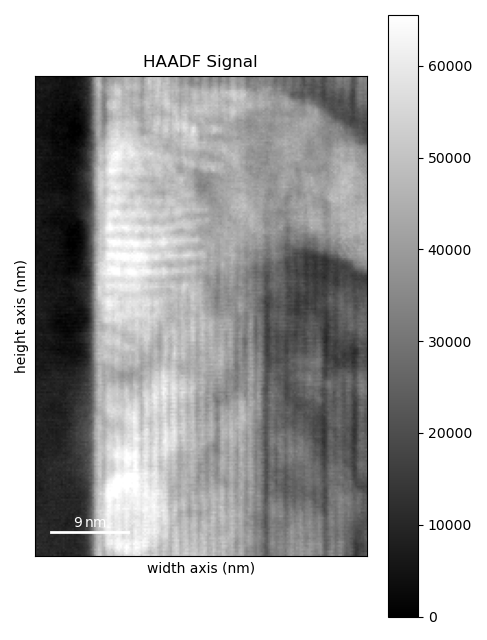

In [12]:
SIimage.plot()

In [13]:
# select desired signal from SIimage and give the file a name for saving
img = SIimage 
img_name = 'HAADF'

<span style="color:blue">Optional:</span> Rotate ROI image for easier visualization/interpretation.  
Here, we put the substrate to the lower side of the image.

[########################################] | 100% Completed | 101.69 ms


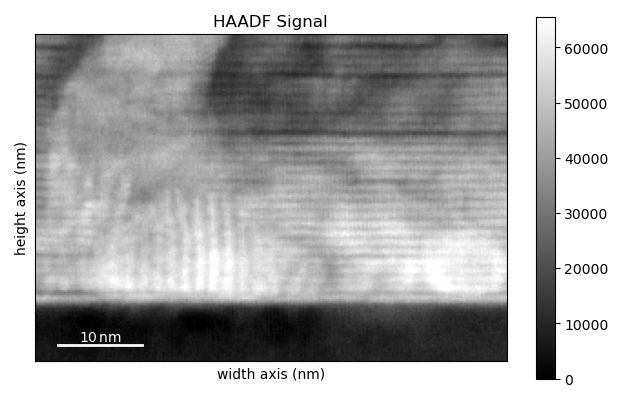

In [14]:
# rotation angle in degrees, counterclockwise rotation
angle = 90
img_rotated = img.map(rotate, angle=angle, reshape=True, parallel=True, show_progressbar=True, inplace=False)
img_rotated.plot()

In [15]:
img = img_rotated
del img_rotated

In [16]:
matplotlib.image.imsave(hyperspy_path / (img_name+'.png'), SIimage.data, cmap='gray')
save_scaled_tiff(img, hyperspy_path / (img_name+'.tif'))
del img
del SIimage

## Pre-Processing

Create folder for storing results during pre-processing:

In [17]:
# Subdirectory for preprocessing steps
preproc_path = hyperspy_path / 'Preprocessing'
create_folder(preproc_path)

save_path = preproc_path

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Preprocessing


First we create some flag variables for documentation (0 = not used, 1 = used)

In [18]:
# Flags for if-statements below initialized to 0, i.e., "False"
fl_rotate = 0
fl_rebin = 0
fl_recal = 0
fl_cropsig = 0
fl_cropnav = 0
fl_gf = 0

### Rotate spectrum image (spatial dimension)
  * Optional: Rotate spectrum image by `angle` in counterclockwise direction, e.g., `angle=90` (degree).
  * Depending on our desired orientation for visualizing the resulting elemental maps, this step saves us from rotating elemental maps/score maps afterward. For `EDS_dataset.bcf', we want to rotate to have the substrate at the bottom part of the elemental maps.
  * Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html

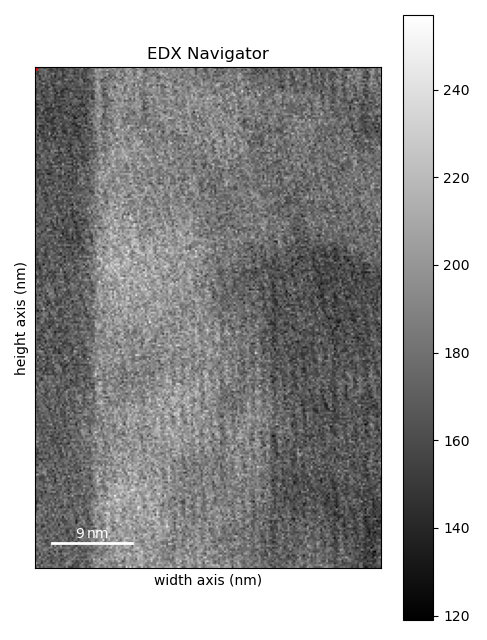

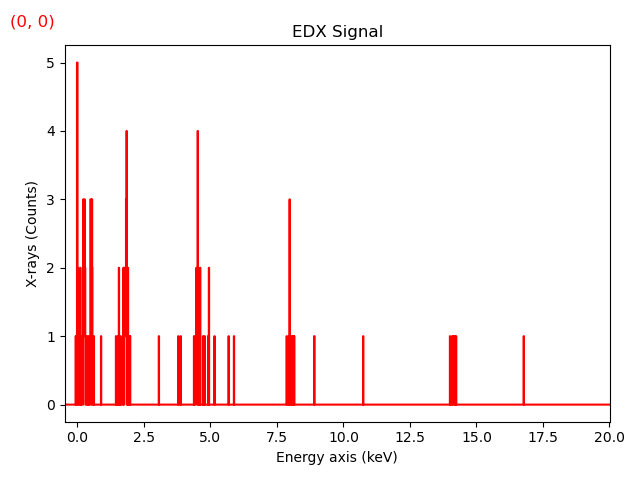

In [19]:
s.plot()

In [20]:
# rotation angle in degrees, counterclockwise rotation
angle = 90 

In [21]:
sr = s.T.map(rotate, angle=angle, reshape=True, parallel=True, show_progressbar=True, inplace=False).T
sr

[########################################] | 100% Completed | 11.32 s


<EDSTEMSpectrum, title: EDX, dimensions: (260, 180|2048)>

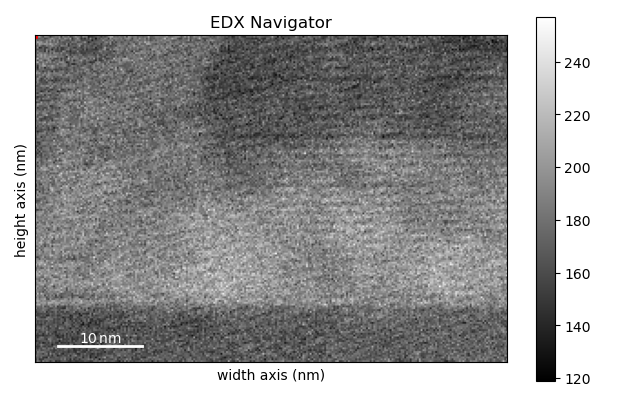

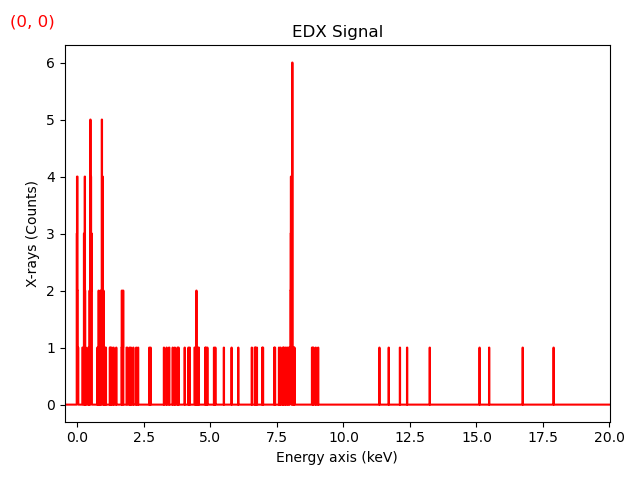

In [22]:
# Inspect rotated SI
sr.plot() 

In [23]:
s = sr # overwrite original SI with rotated version, delete temporary sr file
del sr
fl_rotate = 1 # flag for logfile

### Crop spectrum image (spatial dimension)
  * Optional: Select subregion of SI to speed up analysis and/or to enable rebinning.
  * For later binning of the SI: We can crop our SI to a clean number of spatial dimensions, e.g., 273 to 270, so that modulo is 0, i.e. `270%(rebin factor)=0`. This depends on the `rebin factor` used in the next step.

In [24]:
s

<EDSTEMSpectrum, title: EDX, dimensions: (260, 180|2048)>

In [25]:
# Example: [0:10, :] selects pixels 0-10 in x and all pixels in y direction
#sc = s.inav[0:192, 0:188]

In [26]:
#sc

In [27]:
# inspect cropped image
#sc.plot() 

In [28]:
# overwrite original SI with cropped version, delete temporary sc file
#s = sc 
#del sc
#fl_cropnav = 1 # flag for logfile

### Rebin signal
  * Counts in each pixel are increased (e.g., roughly by a factor of 4 for 2x2 binning)
  * Total number of pixels is reduced (smaller file size). Fewer statistics (pixels) for PCA.
  * In my experience, the higher signal-to-noise ratio after binning may reveal another component for PCA. Also, it often helps to get successful PCA treatment in the first place.
  * For people familiar with Bruker Esprit: (x, y, 1) binning corresponds to the "QMap" factor (typically only 2x, 4x, 8x binning factors available)

Usage: `rebin_fac = [x, y, energy]` will rebin x-y coordinates to increase signal-to-noise ratio at the cost of spatial resolution.

In [29]:
# We use 4x4 here to speed up all following analyses, you can experiment with 2x2 or just Gaussian filtering
rebin_fac = [4, 4, 1] # x, y, energy

sbin = s.deepcopy()
sbin = sbin.rebin(scale=rebin_fac)

Average x-ray counts per pixel (before binning):	181
Average x-ray counts per pixel (after binning):		2891


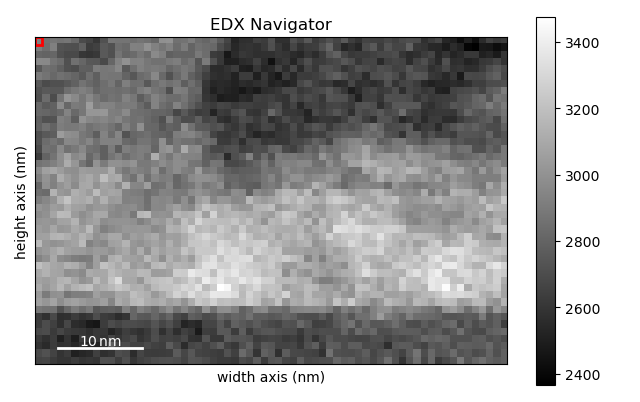

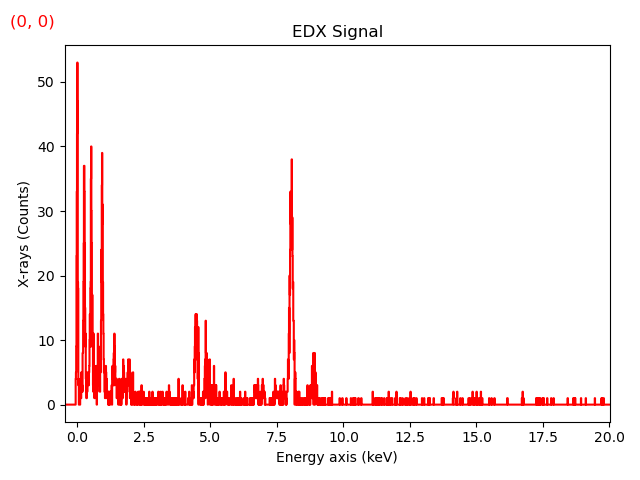

In [30]:
# inspect binned data
print(f'Average x-ray counts per pixel (before binning):\t{np.mean(s.sum(-1).data):.0f}')
print(f'Average x-ray counts per pixel (after binning):\t\t{np.mean(sbin.sum(-1).data):.0f}')
sbin.plot() 

In [31]:
# overwrite original SI with cropped version, delete temporary sc file
s = sbin 
del sbin
fl_rebin = 1 # flag for logfile

### Calibrate energy axis (optional) 
  * Optional: Re-calibrate energy axis (resolution/dispersion/offset) if required.
  * You can typically do this in the EDS vendor software as well before loading the SI here.

In [32]:
#summed_original = s.sum()

In [33]:
#summed_original.axes_manager

In [34]:
#print(f'Energy resolution (Mn Ka):\t\t{summed_original.metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa:.2f} eV')

In [35]:
#summed_calib = summed_original.deepcopy()
#summed_calib = summed_calib.isig[3.5:9.0]

In [36]:
#summed_calib.plot()

In [37]:
#summed_calib.set_elements([]) # erase present element list
#summed_calib.set_microscope_parameters(beam_energy = summed_calib.axes_manager[-1].high_value) # highest energy of cropped signal

Add all possible elements in the sample here.

In [38]:
#summed_calib.add_elements(['Au', 'Ba', 'Cu', 'Er', 'F', 'Gd', 'Hf', 'Ho', 'O', 'Sr', 'Ti', 'Y']) # sample x-rays
#summed_calib.add_elements(['Al', 'C', 'Cu', 'Si', 'Ni', 'Pt', 'Zn', 'Zr']) # artifacts & spurious signal of microscope/grid/contamination...

In [39]:
#m = summed_calib.create_model(auto_background=False)

In [40]:
#m.calibrate_energy_axis(calibrate='resolution')

In [41]:
#m.calibrate_energy_axis(calibrate='offset')

In [42]:
#m.calibrate_energy_axis(calibrate='scale')

In [43]:
#m.axes_manager

In [44]:
#print(f'Energy resolution (Mn Ka):\t\t{summed_original.metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa:.2f} eV')
#print(f'Energy resolution (Mn Ka):\t\t{summed_calib.metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa:.2f} eV')

In [45]:
# Update energy resolution
#s.metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa = summed_calib.metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa

In [46]:
# Update energy scale
#s.axes_manager[-1].scale = summed_calib.axes_manager[-1].scale

### Crop spectrum image (energy dimension)
  * **Recommended for Bruker .bcf files**: Remove the "zero-strobe" peak at 0 eV. This can confuse PCA/NMF because "streaks" are visible in EDS SIs from Bruker coming from variations in peak height in this peak. See an example in Fig 3.18 in this thesis, [https://doi.org/10.5445/IR/1000149357](https://doi.org/10.5445/IR/1000149357))
  * Optional: Remove uninteresting (high) energy range to speed up analysis.

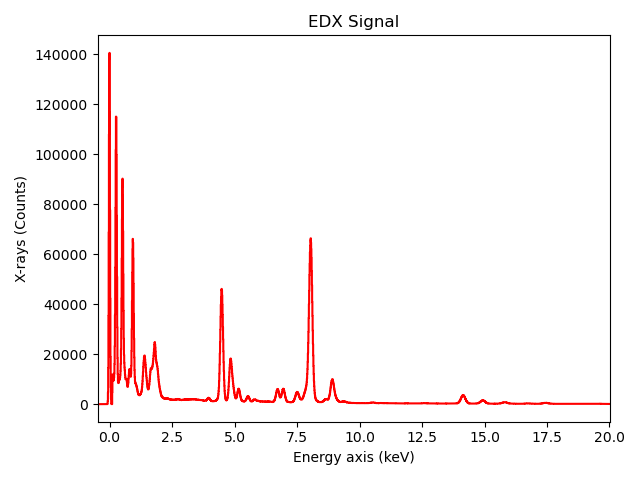

In [47]:
# Plot sum spectrum to inspect the relevant energy range
# Tip: Use the interactive 'Zoom to rectangle' function to zoom into the spectrum plot
s.sum().plot() 

In [48]:
# Use startE = None or endE = None if no cropping is desired at one of the sides
startE = '0.14 keV'
endE = None

sbinE = s.isig[startE:endE]

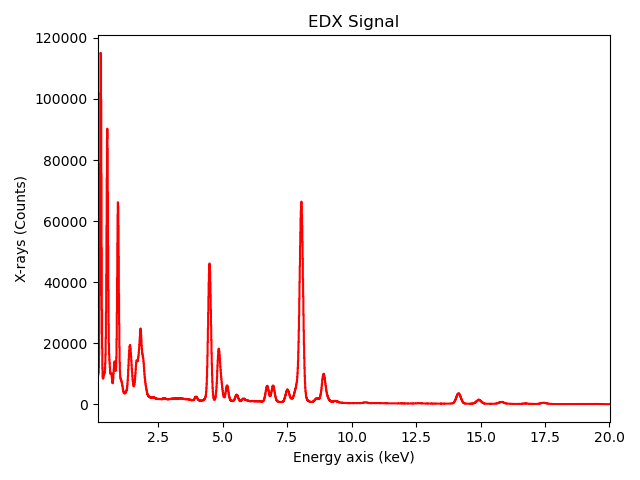

In [49]:
# inspect cropped energy range
sbinE.sum().plot()

Alternative: Select energy region interactively:

In [50]:
#Interactive cropping:
#s.crop_signal1D()
#fl_cropsig = 1 #flag for logfile

Overwrite original SI with cropped version:

In [51]:
# overwrite original SI with energy-cropped version, delete temporary sbinE file
s = sbinE 
del sbinE
fl_cropsig = 1 # flag for logfile

### Gaussian Filtering
  * Convolute a Gaussian smoothing kernel over spatial and/or energy dimensions and mix the EDS spectrum at each pixel with the weighted EDS spectra of surrounding pixels. The size of the Gaussian distribution parameters `sigma` (and `truncate`) should be adjusted to some "sensible" values, i.e., think about overlap between neighboring pixel due to probe size/beam broadening/signal volume... Might require some trial and error.
  * Should be useful in case of obvious signal mixing between pixels (e.g., for strongly oversampled EDS datasets with, e.g., 40 pm pixel size and a 150 pm probe diameter).
  * If in doubt, use simple rebinning instead.
  * See also the papers by **Pavel Potapov et al.**: https://doi.org/10.1016/j.micron.2017.02.001 and https://doi.org/10.1186/s40679-019-0066-0
  * It is also possible to convolute the energy dimension to increase the signal-to-noise ratio, but this may affect the energy resolution (quite unexplored territory).

1) Check current spatial sampling of the SI

In [52]:
print(f'Spatial sampling:\t\t\t{s.axes_manager[0].scale:.6f} {s.axes_manager[0].units}/pixel')

Spatial sampling:			0.865102 nm/pixel


2. Generate and visualize a Gaussian smoothing kernel  
The pixel value corresponds to the weighting factor of the pixel neighborhood.

In [53]:
from scipy.ndimage import gaussian_filter

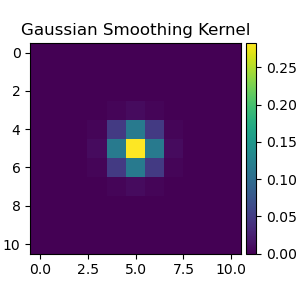

In [54]:
# Adjust these parameters to your needs
kernel_dim = 11 # kernel_dim x kernel_dim, window size of the Gaussian kernel
sigma = 0.75
trunc = 4

# Create pixel window
np.floor(kernel_dim/2)
a = np.zeros((kernel_dim, kernel_dim))
a[int(np.floor(kernel_dim/2)), int(np.floor(kernel_dim/2))] = 1

# Plot kernel
from mpl_toolkits.axes_grid1 import make_axes_locatable

kernel = gaussian_filter(a, sigma=sigma, truncate=trunc)

fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(kernel)
ax.set_title('Gaussian Smoothing Kernel')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
fig.tight_layout(pad=0.2)

Save kernel image:

In [55]:
fig.savefig(save_path / f'Gaussian_filter_kernel_sigma{sigma}_trunc{trunc}.svg')
fig.savefig(save_path / f'Gaussian_filter_kernel_sigma{sigma}_trunc{trunc}.png', dpi=300)

In [56]:
# Save as tiff file for ImageJ/Fiji
kernel_img = hs.signals.Signal2D(kernel)
kernel_img.axes_manager[0].name = 'X'; kernel_img.axes_manager[0].name = 'Y'
kernel_img.axes_manager[0].scale = s.axes_manager[0].scale; kernel_img.axes_manager[1].scale = s.axes_manager[1].scale
kernel_img.axes_manager[0].units = s.axes_manager[0].units; kernel_img.axes_manager[1].units = s.axes_manager[1].units
save_scaled_tiff(kernel_img, save_path / f'Gaussian_filter_kernel_sigma{sigma}_trunc{trunc}.tif')

3. Dataset has to be converted to float for filtering:

In [57]:
s.change_dtype('float')

4. Choose the filtering dimension and run the filter:

In [58]:
# Spatial dimension (default)
sg = s.T.map(gaussian_filter, sigma=sigma, truncate=trunc, inplace=False, parallel=True).T

[########################################] | 100% Completed | 202.67 ms


In [59]:
# Energy dimension
#sg = sg.map(gaussian_filter, sigma=sigma, truncate=trunc, inplace=False, parallel=True)

In [60]:
# Spatial and energy, i.e., 3D kernel for Gaussian filtering
#sg = gaussian_filter(s, sigma=sigma, truncate=trunc)
#sg = hs.signals.Signal1D(sg)
#sg.axes_manager = s.axes_manager

5. Inspect the resulting Gaussian-filtered SI:

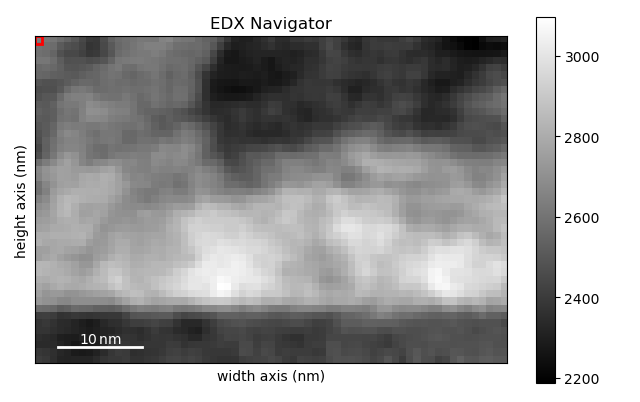

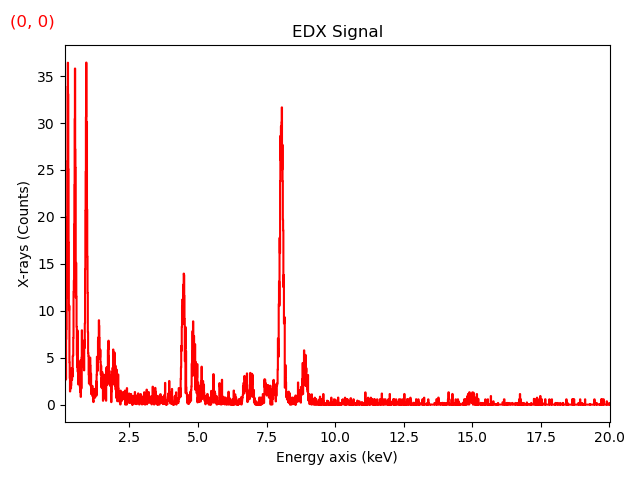

In [61]:
sg.plot()

6. Overwrite `s` with `sg`:

In [62]:
s = sg
del sg
fl_gf = 1 # for logfile

### Finalize Pre-Processing

#### Create logfile of data treatment

In [63]:
f = open(save_path / 'PreProcessingSteps.txt', 'w')
    
statement = 'Data treatment performed on SI:\n'
print(statement)
f.write(statement)
if fl_rotate:
    statement = f'Rotated SI by {angle:.2f} deg.\n'
    print(statement)
    f.write(statement)
if fl_cropnav:
    statement = f'Cropped image to smaller dimensions: ({np.shape(s)[1]} , {np.shape(s)[0]})\n' # (col,row)
    print(statement)
    f.write(statement)
if fl_rebin:    
    statement = f'Rebin factor (x,y,E): {rebin_fac[0]} x {rebin_fac[1]} x {rebin_fac[2]}\n'
    print(statement)
    f.write(statement)
if fl_cropsig:
    statement = f'Cropped signal (energy, keV): {s.axes_manager.signal_extent[0]:.3f} to  {s.axes_manager.signal_extent[1]:.3f}\n'
    print(statement)
    f.write(statement)
if fl_gf:
    statement = f'Gaussian filter with sigma = {sigma:.2f} pixels and truncation = {trunc:.2f} pixels\n'
    print(statement)
    f.write(statement)
f.close()

Data treatment performed on SI:

Rotated SI by 90.00 deg.

Rebin factor (x,y,E): 4 x 4 x 1

Cropped signal (energy, keV): 0.137 to  20.013

Gaussian filter with sigma = 0.75 pixels and truncation = 4.00 pixels



#### Inspect and save pre-processed dataset

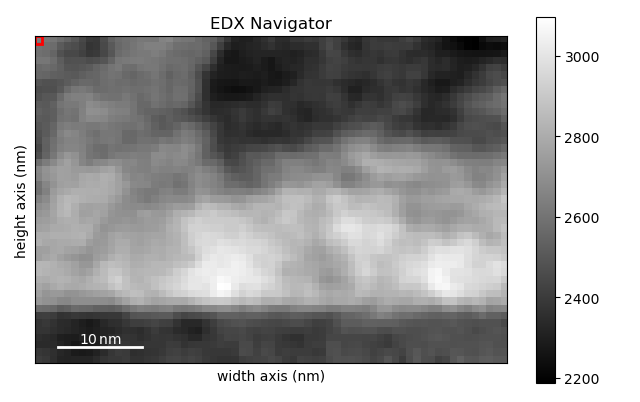

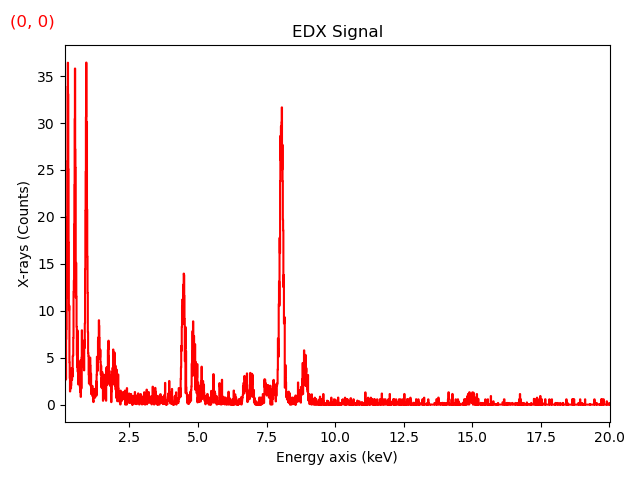

In [64]:
# inspect pre-processed SI
s.plot()

In [65]:
# save pre-processed SI
s.save(filename=save_path / (s.metadata.General.original_filename.rsplit('.', maxsplit=1)[0] + '_preprocessed.hspy'),
       overwrite=True) 

## Multivariate Statistical Analysis

In [66]:
# Convert data to float for calculations
s.change_dtype('float') 

### PCA decomposition and denoise

In [67]:
# Subdirectory for PCA results
PCA_path = hyperspy_path / 'PCA'
create_folder(PCA_path)

save_path = PCA_path

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/PCA


We run PCA using the established singular value decomposition (SVD) method.  
Since we deal with Poissonian-type noise in x-ray counting experiments, we normalize the noise to Gaussian type, as required for standard PCA.  
The `navigation_mask=None` is required, since some of the pixels after possible Gaussian filtering might have an average max count < 1.

#### 1. Perform PCA

In [68]:
%%timeit -r 1 -n 1
s.decomposition(normalize_poissonian_noise=True, navigation_mask=None) # navigation_mask parameter is required for Gaussian filtering

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
5.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### 2. Inspect PCA results

After PCA, we inspect 
  - the [scree plot](https://en.wikipedia.org/wiki/Scree_plot), 
  - the score maps, 
  - and factors/loadings
 
to decide on the **number of relevant components** used for reconstruction.  
Note that the score maps (i.e., spatial distributions) and EDS-like factors are quite abstract and not easily interpretable as chemical phases after PCA.

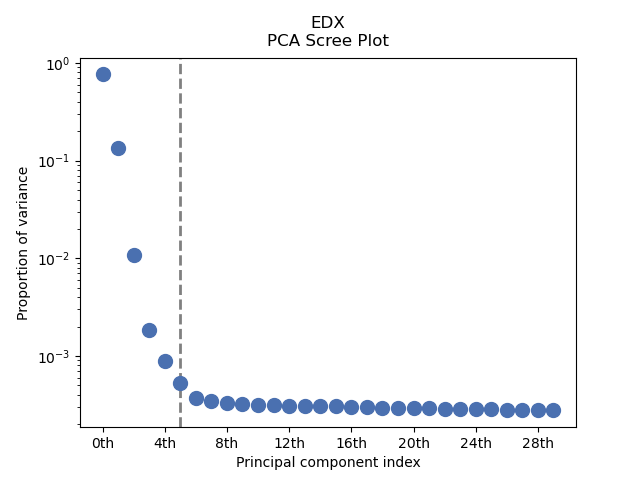

In [69]:
# Scree plot
s.plot_explained_variance_ratio(n=30, vline=True)
s.get_explained_variance_ratio().save(save_path / 'Screeplot.hspy', overwrite=True)
plt.gcf().savefig(save_path / 'Screeplot.png', dpi=300)
plt.gcf().savefig(save_path / 'Screeplot.svg')

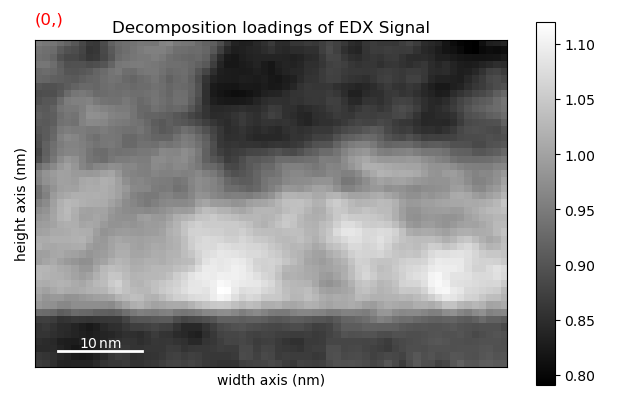

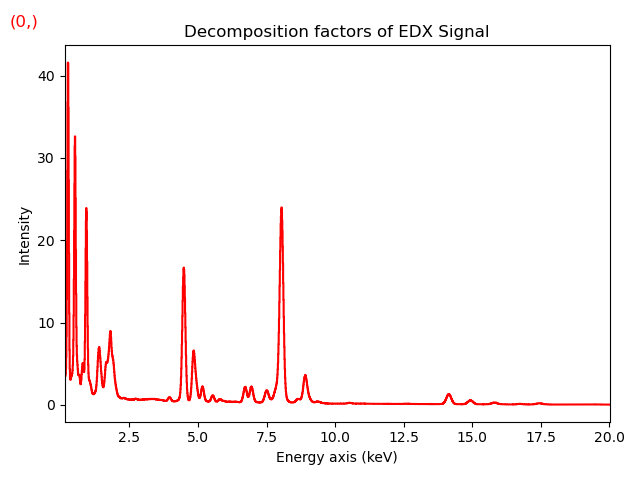

In [70]:
# Plot score maps (spatial distributions) and factors (EDS-spectrum-like signals)
# Use left/right on the keyboard or the index slider to inspect the first few components for abstract signals
# Find the map/factor where the results are becoming just random noise
# This should correspond roughly to the 'elbow position' in the scree plot above
s.plot_decomposition_results()

#### 3. Specify the number of meaningful components in dataset
Choose the principal components to use for data-set reconstruction.  
If in doubt: More components only increase the noise level in the dataset, whereas removing actual signal will alter interpretation of experimental results!  
**Therefore, we use 1-2 more components if we are unsure about the exact cut-off value**.

In [79]:
# Specify list of meaningful components
# Benefit of using a list: You can discard components from experimental artifacts, but preprocessing should remove them already!
Nlist = [0,1,2,3,4,5,6] 
N = len(Nlist)

Reconstruct datacube with $N$ meaningful components, i.e. create denoised dataset. Save dataset.  


In [80]:
PCA_filtered = s.get_decomposition_model(Nlist)
PCA_filtered.save(save_path / f'PCA_filtered_{N}.hspy')
print(f'Dimensionality reduction from {s.axes_manager[-1].size} energy channels to {N} principal components.')

Overwrite '/home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/PCA/PCA_filtered_7.hspy' (y/n)?
 y


Dimensionality reduction from 1986 energy channels to 7 principal components.


Save real space dimensions of dataset for later inspection if needed:

In [81]:
#Save spatial calibration data to textfile
Mapsize = [PCA_filtered.axes_manager[0].scale*np.shape(PCA_filtered)[0], PCA_filtered.axes_manager[1].scale*np.shape(PCA_filtered)[1]]

#save to txt file
f = open(save_path / 'Scale.txt', 'w')
f.write('Scale for PCA-filtered maps:\n')
f.write(f'Dimensions:\t\t\t\t {PCA_filtered.axes_manager[0].size} x {PCA_filtered.axes_manager[1].size}\n')
f.write(f'Physical pixel size:\t {PCA_filtered.axes_manager[0].scale:.4f} {PCA_filtered.axes_manager[0].units}\n')
f.write(f'Physical map size:\t\t {Mapsize[1]:.4f} x {Mapsize[0]:.4f} nm')
f.close()

<span style="color:blue">Optional:</span> Visualize original and noise-reduced data at each pixel.

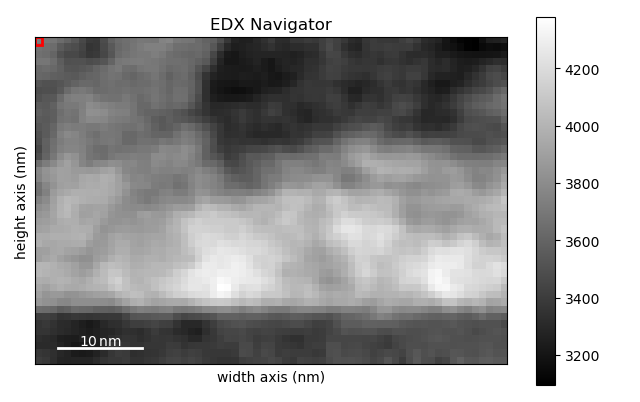

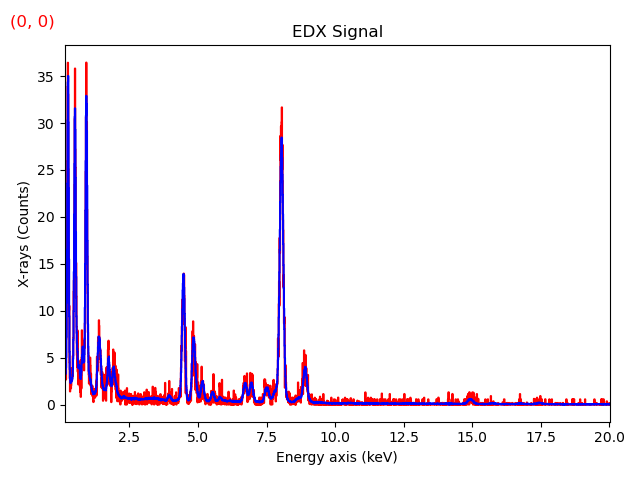

In [82]:
(s + PCA_filtered * 1j).plot()

<span style="color:blue">Optional:</span> Visualize difference between original and noise-reduced data at each pixel.

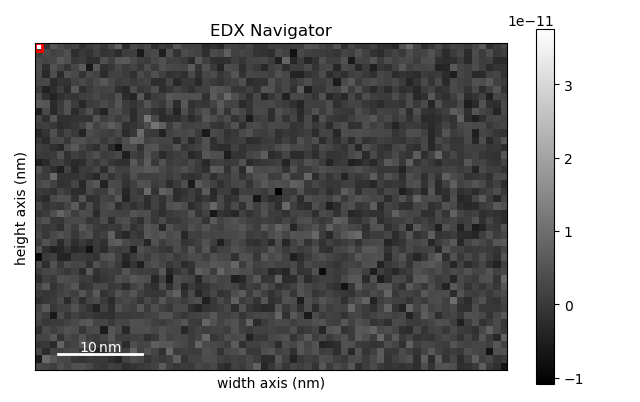

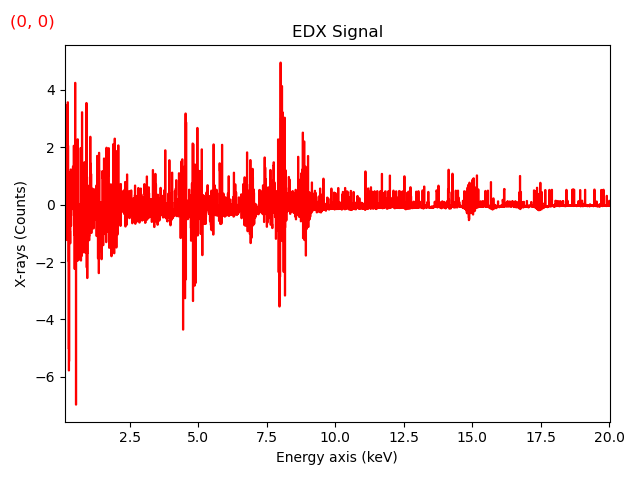

In [83]:
(s - PCA_filtered).plot()

**Note**: The `PCA_filtered_N.hspy` dataset is used in the 'Part 2' notebook to extract elemental maps.  
Therefore, you can stop here if you just want to extract elemental maps. The following part will contain other decomposition algorithms for possible data mining of the EDS dataset.

## MSA - Blind Source Separation from previous PCA Decomposition
Attempt to (i) automatically determine chemical phases or (ii) separate overlapping chemical phases using different algorithms.  
Requires previous PCA calculation.

### Independent Component Analysis (ICA)
Do ICA blind source separation with $N$ dimensions as determined from PCA scree plot. You can overwrite this by changing the `output_dimension` parameter. 

In [84]:
# Define a string for naming the save folder for the results
method = 'ICA'

In [85]:
%%timeit -r 1 -n 1
s.blind_source_separation(algorithm='sklearn_fastica', 
                          number_of_components=N, 
                          max_iter=2000)

[########################################] | 100% Completed | 101.97 ms


Blind source separation info:
  number_of_components=7
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(max_iter=2000, tol=1e-10, whiten=False)
436 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/lukas/miniconda3/envs/hspy175/lib/python3.10/site-packages/hyperspy/drawing/utils.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


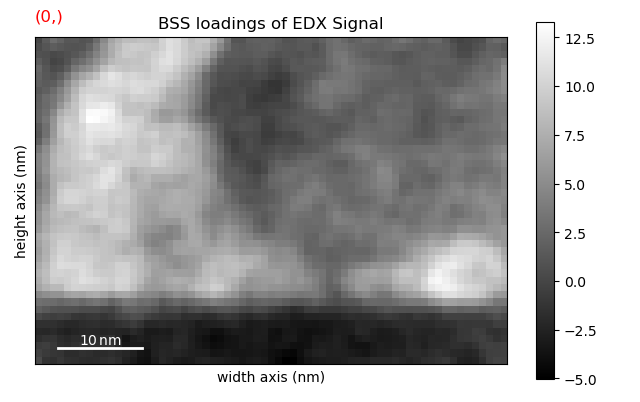

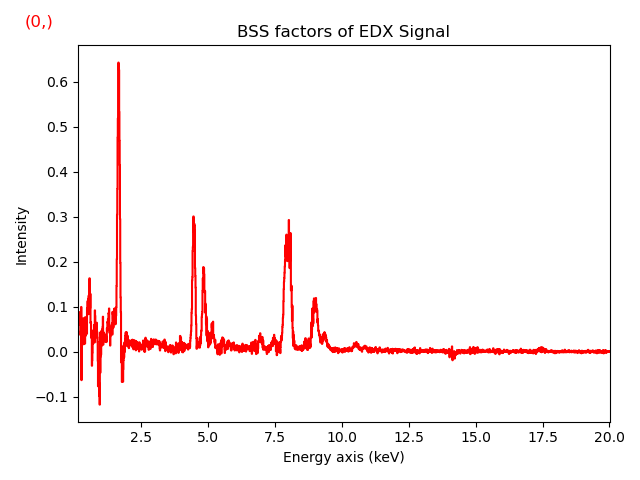

In [86]:
s.plot_bss_results()

In [87]:
# Subdirectory for ICA results
method_path = hyperspy_path / method
create_folder(method_path)

save_path = method_path

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/ICA


In [88]:
per_row = 3

# Get factors and loadings (score maps)
fac = s.get_bss_factors()
load = s.get_bss_loadings()

# Create folders
save_path_spec = save_path / 'Spectra' 
save_path_maps = save_path / 'Score maps' 
save_path_maps_png = save_path_maps / 'png'
save_path_maps_svg = save_path_maps / 'svg'
save_path_maps_tiff = save_path_maps / 'tiff'

create_folder(save_path_spec); create_folder(save_path_maps); create_folder(save_path_maps_png); create_folder(save_path_maps_svg); create_folder(save_path_maps_tiff);

# Save overviews
hs.plot.plot_spectra(fac, style='mosaic', legend='auto', tight_layout=True)[0].figure.savefig(save_path / (method+'_spectra.png'), dpi=600)
hs.plot.plot_images(load, tight_layout=True, cmap='viridis', scalebar=None, axes_decor='off', per_row=per_row)[0].figure.savefig(save_path / (method+'_score_maps.png'), dpi=600)
plt.close('all')

# Save data in various formats
fac.save(save_path_spec / (method+'_factors.hspy'), overwrite=True) #for optional later use
load.save(save_path_maps / (method+'_score_maps.hspy'), overwrite=True) #for optional later use
[fac.inav[i].save(save_path_spec / f'ICA_Factor_{i}.msa', overwrite=True) for i in range(N)] #.msa for Esprit/DTSA/...
for i in range(N):
    matplotlib.image.imsave(save_path_maps_png / f'{method}_ScoreMap_{i}.png', load.data[i,:,:], cmap='gray') # png
    #matplotlib.image.imsave(save_path_maps_svg / f'{method}_ScoreMap_{i}.svg', load.data[i,:,:], cmap='gray') # svg
    save_scaled_tiff(load.inav[i], save_path_maps_tiff / f'{method}_ScoreMap_{i}.tif') # scaled tiff

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/ICA/Spectra
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/ICA/Score maps
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/ICA/Score maps/png
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/ICA/Score maps/svg
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/ICA/Score maps/tiff


### Varimax Rotation
Do Varimax factor rotation for blind source separation with $N$ dimensions as determined from PCA scree plot. You can overwrite this by changing the `output_dimension` parameter.

In [89]:
# Define a string for naming the save folder for the results
method = 'Varimax'

In [90]:
%%timeit -r 1 -n 1
s.blind_source_separation(algorithm='orthomax', 
                          gamma=1.0, 
                          number_of_components=N, 
                          max_iter=2000)

[########################################] | 100% Completed | 102.90 ms
Blind source separation info:
  number_of_components=7
  algorithm=orthomax
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
217 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


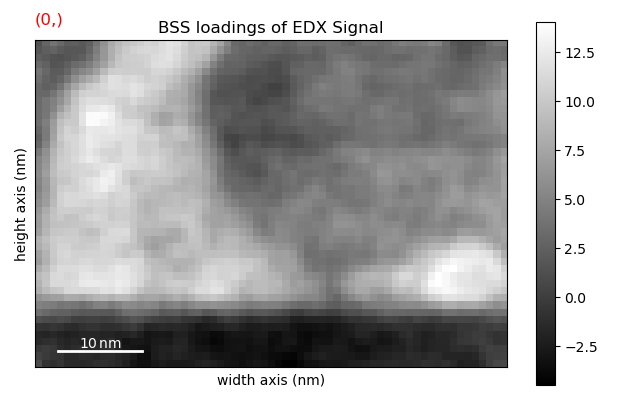

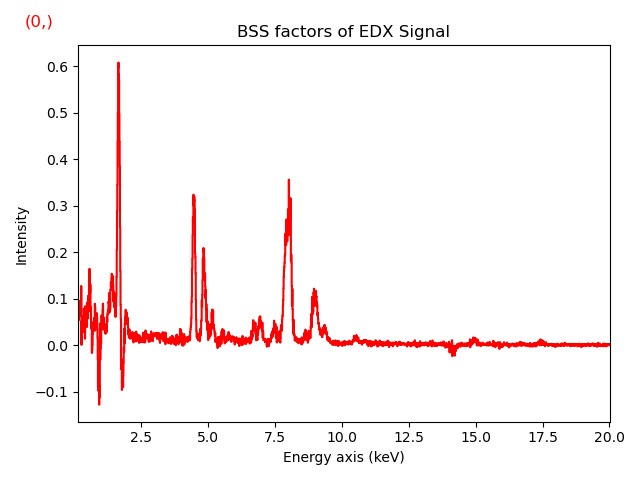

In [91]:
s.plot_bss_results()

In [92]:
# Subdirectory for Varimax results
method_path = hyperspy_path / method
create_folder(method_path)

save_path = method_path

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Varimax


In [93]:
per_row = 3

# Get factors and loadings (score maps)
fac = s.get_bss_factors()
load = s.get_bss_loadings()

# Create folders
save_path_spec = save_path / 'Spectra' 
save_path_maps = save_path / 'Score maps' 
save_path_maps_png = save_path_maps / 'png'
save_path_maps_svg = save_path_maps / 'svg'
save_path_maps_tiff = save_path_maps / 'tiff'

create_folder(save_path_spec); create_folder(save_path_maps); create_folder(save_path_maps_png); create_folder(save_path_maps_svg); create_folder(save_path_maps_tiff);

# Save overviews
hs.plot.plot_spectra(fac, style='mosaic', legend='auto', tight_layout=True)[0].figure.savefig(save_path / (method+'_spectra.png'), dpi=600)
hs.plot.plot_images(load, tight_layout=True, cmap='viridis', scalebar=None, axes_decor='off', per_row=per_row)[0].figure.savefig(save_path / (method+'_score_maps.png'), dpi=600)
plt.close('all')

# Save data in various formats
fac.save(save_path_spec / (method+'_factors.hspy'), overwrite=True) #for optional later use
load.save(save_path_maps / (method+'_score_maps.hspy'), overwrite=True) #for optional later use
[fac.inav[i].save(save_path_spec / f'ICA_Factor_{i}.msa', overwrite=True) for i in range(N)] #.msa for Esprit/DTSA/...
for i in range(N):
    matplotlib.image.imsave(save_path_maps_png / f'{method}_ScoreMap_{i}.png', load.data[i,:,:], cmap='gray') # png
    #matplotlib.image.imsave(save_path_maps_svg / f'{method}_ScoreMap_{i}.svg', load.data[i,:,:], cmap='gray') # svg
    save_scaled_tiff(load.inav[i], save_path_maps_tiff / f'{method}_ScoreMap_{i}.tif') # scaled tiff

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Varimax/Spectra
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Varimax/Score maps
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Varimax/Score maps/png
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Varimax/Score maps/svg
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/Varimax/Score maps/tiff


## MSA - Other Decomposition Methods
Attempt to (i) automatically determine chemical phases or (ii) separate overlapping chemical phases using different algorithms.  
Note that we need to use, e.g., `s.get_decomposition_loadings()` instead of `s.get_bss_loadings()` from the previous unmixing methods.

### Non-Negative Matrix Factorization (NMF)
Do NMF decomposition with $N$ dimensions as determined from PCA scree plot. You can overwrite this by changing the `output_dimension` parameter.  
Link: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [94]:
%%timeit -r 1 -n 1
s.decomposition(normalize_poissonian_noise=True, 
                algorithm='NMF', 
                output_dimension=N, 
                max_iter=2000)
#s.decomposition(normalize_poissonian_noise=True, algorithm='NMF', output_dimension=N, max_iter=2000, solver = 'mu', beta_loss='kullback-leibler')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=7
  centre=None
scikit-learn estimator:
NMF(max_iter=2000, n_components=7)
26.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/lukas/miniconda3/envs/hspy175/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


Inspect NMF decomposition results

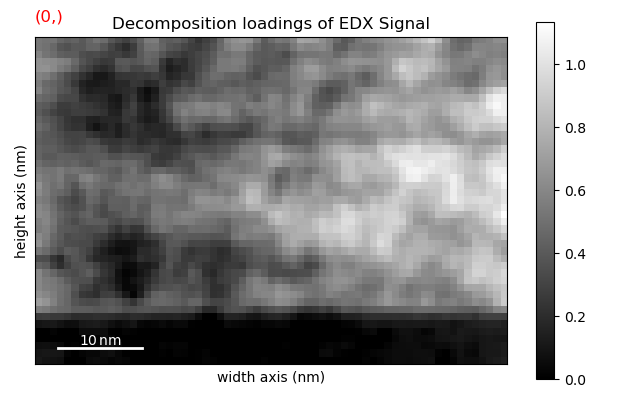

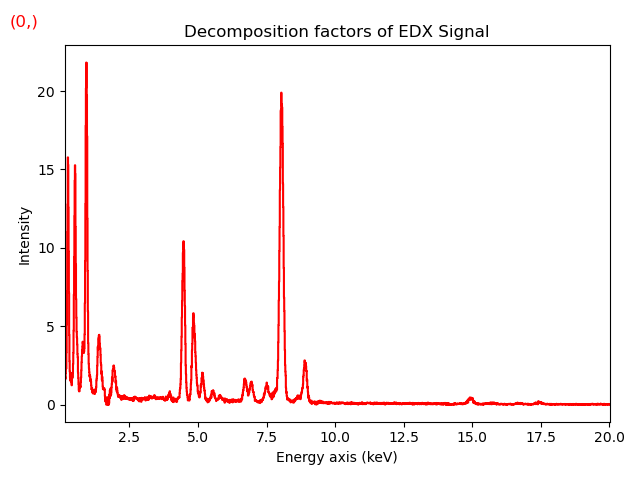

In [95]:
s.plot_decomposition_results()

Save overviews and all data:

In [96]:
# Define a string for naming the save folder for the results
method = 'NMF'

In [97]:
# Subdirectory for NMF results
method_path = hyperspy_path / method
create_folder(method_path)

save_path = method_path

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/NMF


In [98]:
per_row = 3

# Get factors and loadings (score maps)
fac = s.get_decomposition_factors()
load = s.get_decomposition_loadings()

# Create folders
save_path_spec = save_path / 'Spectra' 
save_path_maps = save_path / 'Score maps' 
save_path_maps_png = save_path_maps / 'png'
save_path_maps_svg = save_path_maps / 'svg'
save_path_maps_tiff = save_path_maps / 'tiff'

create_folder(save_path_spec); create_folder(save_path_maps); create_folder(save_path_maps_png); create_folder(save_path_maps_svg); create_folder(save_path_maps_tiff);

# Save overviews
hs.plot.plot_spectra(fac, style='mosaic', legend='auto', tight_layout=True)[0].figure.savefig(save_path / (method+'_spectra.png'), dpi=600)
hs.plot.plot_images(load, tight_layout=True, cmap='viridis', scalebar=None, axes_decor='off', per_row=per_row)[0].figure.savefig(save_path / (method+'_score_maps.png'), dpi=600)
plt.close('all')

# Save data in various formats
fac.save(save_path_spec / (method+'_factors.hspy'), overwrite=True) #for optional later use
load.save(save_path_maps / (method+'_score_maps.hspy'), overwrite=True) #for optional later use
[fac.inav[i].save(save_path_spec / f'ICA_Factor_{i}.msa', overwrite=True) for i in range(N)] #.msa for Esprit/DTSA/...
for i in range(N):
    matplotlib.image.imsave(save_path_maps_png / f'{method}_ScoreMap_{i}.png', load.data[i,:,:], cmap='gray') # png
    #matplotlib.image.imsave(save_path_maps_svg / f'{method}_ScoreMap_{i}.svg', load.data[i,:,:], cmap='gray') # svg
    save_scaled_tiff(load.inav[i], save_path_maps_tiff / f'{method}_ScoreMap_{i}.tif') # scaled tiff

Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/NMF/Spectra
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/NMF/Score maps
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/NMF/Score maps/png
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/NMF/Score maps/svg
Successfully created the directory /home/lukas/Documents/GitHub/eds-processing-notebooks/notebooks/data_processing_explained/HyperSpy_Analysis/NMF/Score maps/tiff
